## Лаборатторная работа №2 (классификация)


Для начала подгрузим необходимые библиотеки

In [87]:
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score

Подгрузим датасет

In [21]:
df_train = pd.read_csv('../datasets/titanic/train.csv')
df_test = pd.read_csv('../datasets/titanic/test.csv')

In [22]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
print(f'Размер исходного датасета: {len(df_train)}')

Размер исходного датасета: 891


In [24]:
combine = [df_train, df_test]

In [25]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for df in combine:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna(0)
    df.drop(["Name"], axis=1, inplace=True)

In [26]:
for df in combine:
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [27]:
for df in combine:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
    df.drop(['FamilySize', 'SibSp', 'Parch'], axis=1, inplace=True)

In [28]:
pd.cut(df_train['Age'], 5).unique()

[(16.336, 32.252], (32.252, 48.168], NaN, (48.168, 64.084], (0.34, 16.336], (64.084, 80.0]]
Categories (5, interval[float64]): [(0.34, 16.336] < (16.336, 32.252] < (32.252, 48.168] < (48.168, 64.084] < (64.084, 80.0]]

In [29]:
for df in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = df[(df['Sex'] == i) & \
                                  (df['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()
            age_guess = int(age_guess/0.5 + 0.5) * 0.5
            
            df.loc[(df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j+1),\
                   'Age'] = age_guess
            
    df['Age'] = df['Age'].astype(int)
    df.loc[ df['Age'] <= 16, 'Age'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
    df.loc[ df['Age'] > 64, 'Age'] = 4

In [30]:
for df in combine:
    df['Embarked'].fillna('S', inplace=True)
    df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [31]:
pd.qcut(df_train['Fare'], 4).unique()

[(-0.001, 7.91], (31.0, 512.329], (7.91, 14.454], (14.454, 31.0]]
Categories (4, interval[float64]): [(-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]]

In [ ]:
for df in combine:
    df['Fare'].fillna(df['Fare'].dropna().median(), inplace=True)
    df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    df.loc[ df['Fare'] > 31, 'Fare'] = 3
    df['Fare'] = df['Fare'].astype(int)

In [ ]:
for df in combine:
    df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [ ]:
df_train.drop(["PassengerId"], axis=1, inplace=True)

combine = [df_train, df_test]

In [ ]:
print("Процент выживших {:.2%}".format((df_train["Survived"] == 1).sum()/len(df_train)))

In [ ]:
X_train = df_train.drop("Survived", axis=1)
Y_train = df_train["Survived"]
X_test  = df_test.drop("PassengerId", axis=1).copy()

In [ ]:
parameters = {
    'n_neighbors': [2, 3, 4, 5, 10 ,15],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(X_train, Y_train)
Y_pred_knn = clf.predict_proba(X_train)[:,1]
print('score {:.2%}'.format(clf.score(X_train, Y_train)))
print(clf.best_params_)

In [ ]:
fpr, tpr, _ = roc_curve(Y_train, Y_pred_knn)
auc_roc = roc_auc_score(Y_train, Y_pred_knn)
plt.plot(fpr,tpr,label="auc={:.4}".format(auc_roc))
plt.legend(loc=4)
plt.show()

In [ ]:
parameters = {
    'radius': [2, 3, 4, 5],
    'weights': ['uniform', 'distance']
}

rnc = RadiusNeighborsClassifier()
clf = GridSearchCV(rnc, parameters)
clf.fit(X_train, Y_train)
Y_pred_rn = clf.predict(X_train)
print('score {:.2%}'.format(clf.score(X_train, Y_train)))
print(clf.best_params_)

In [ ]:
fpr, tpr, _ = roc_curve(Y_train, Y_pred_rn)
auc_roc = roc_auc_score(Y_train, Y_pred_rn)
plt.plot(fpr,tpr,label="auc={:.4}".format(auc_roc))
plt.legend(loc=4)
plt.show()

In [32]:
fpr, tpr, _ = roc_curve(Y_train, Y_pred_rn)
auc_roc = roc_auc_score(Y_train, Y_pred_rn)
plt.plot(fpr,tpr,label="auc={:.4}".format(auc_roc))
plt.legend(loc=4)
plt.show()

In [33]:
for df in combine:
    df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [34]:
df_train.drop(["PassengerId"], axis=1, inplace=True)

combine = [df_train, df_test]

In [35]:
print("Процент выживших {:.2%}".format((df_train["Survived"] == 1).sum()/len(df_train)))

Процент выживших 38.38%


In [36]:
X_train = df_train.drop("Survived", axis=1)
Y_train = df_train["Survived"]
X_test  = df_test.drop("PassengerId", axis=1).copy()

In [96]:
parameters = {
    'n_neighbors': [2, 3, 4, 5, 10 ,15],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(X_train, Y_train)
Y_pred_knn = clf.predict_proba(X_train)[:,1]
print('score {:.2%}'.format(clf.score(X_train, Y_train)))
print(clf.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


score 86.08%
{'n_neighbors': 4, 'weights': 'distance'}


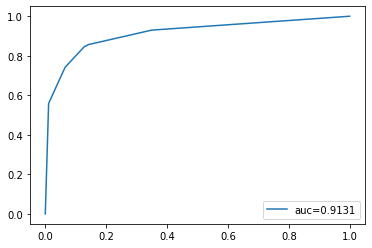

In [98]:
fpr, tpr, _ = roc_curve(Y_train, Y_pred_knn)
auc_roc = roc_auc_score(Y_train, Y_pred_knn)
plt.plot(fpr,tpr,label="auc={:.4}".format(auc_roc))
plt.legend(loc=4)
plt.show()

In [109]:
parameters = {
    'radius': [2, 3, 4, 5],
    'weights': ['uniform', 'distance']
}

rnc = RadiusNeighborsClassifier()
clf = GridSearchCV(rnc, parameters)
clf.fit(X_train, Y_train)
Y_pred_rn = clf.predict(X_train)
print('score {:.2%}'.format(clf.score(X_train, Y_train)))
print(clf.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


score 86.64%
{'radius': 2, 'weights': 'distance'}


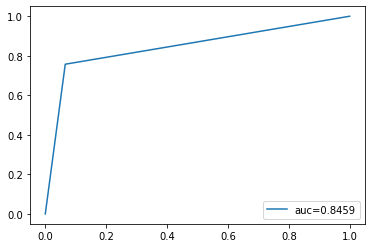

In [110]:
fpr, tpr, _ = roc_curve(Y_train, Y_pred_rn)
auc_roc = roc_auc_score(Y_train, Y_pred_rn)
plt.plot(fpr,tpr,label="auc={:.4}".format(auc_roc))
plt.legend(loc=4)
plt.show()